# E-Commerce Customer Behavior Analysis
**Author:** Ahmed Lotfy | [LinkedIn](https://www.linkedin.com/in/ahmedmlotfy0) | [GitHub](https://www.github.com/ahmedmlotfy0)

---

## 1. Executive Summary & Introduction
In the crowded world of e-commerce, data is the voice of the customer. In this project, we listen to transaction data to understand customer behavior, uncover buying patterns, and help the business build stronger relationships.

**Business Goals:**
1.  **Understand the Heartbeat:** Analyze sales trends and seasonality.
2.  **Customer Segmentation (RFM):** Identify our "Superstars" and "At-Risk" customers.
3.  **Retention Strategy:** Use Cohort Analysis to measure customer loyalty.
4.  **Product Strategy:** Discover product associations using Market Basket Analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Online Retail II/online_retail_II.csv",parse_dates=["InvoiceDate"],dtype={"Quantity":"int32","Price":"float32","Customer ID":"Int32"})
df.rename(columns={"Invoice":"invoice","StockCode":"stock_code","Description":"description","Quantity":"quantity","InvoiceDate":"invoice_date","Price":"price","Customer ID":"customer_id","Country":"country"},inplace=True)
df['description'] = df['description'].str.strip()
df = df[~df['invoice'].str.contains('C')]
df = df[df['quantity'] > 0]
df.dropna(subset=['invoice', 'stock_code'], inplace=True)
df.head()

,invoice,stock_code,description,quantity,invoice_date,price,customer_id,country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1044420 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   invoice       1044420 non-null  object        
 1   stock_code    1044420 non-null  object        
 2   description   1042727 non-null  object        
 3   quantity      1044420 non-null  int32         
 4   invoice_date  1044420 non-null  datetime64[ns]
 5   price         1044420 non-null  float32       
 6   customer_id   805620 non-null   Int32         
 7   country       1044420 non-null  object        
dtypes: Int32(1), datetime64[ns](1), float32(1), int32(1), object(4)
memory usage: 60.8+ MB


In [4]:
df.describe().round(1)

,quantity,invoice_date,price,customer_id
count,1044420.0,1044420,1044420.0,805620.0
mean,11.2,2011-01-03 13:09:03.506060032,3.9,15331.9
min,1.0,2009-12-01 07:45:00,-53594.4,12346.0
25%,1.0,2010-07-11 14:19:00,1.2,13982.0
50%,3.0,2010-12-07 15:32:00,2.1,15271.0
75%,10.0,2011-07-24 11:25:00,4.1,16805.0
max,80995.0,2011-12-09 12:50:00,25111.1,18287.0
std,129.5,NaN,94.5,1696.8


## 2. The Store's Heartbeat: Sales Trend Analysis
**Business Question:** How is our revenue performing over time? Are we growing or shrinking?

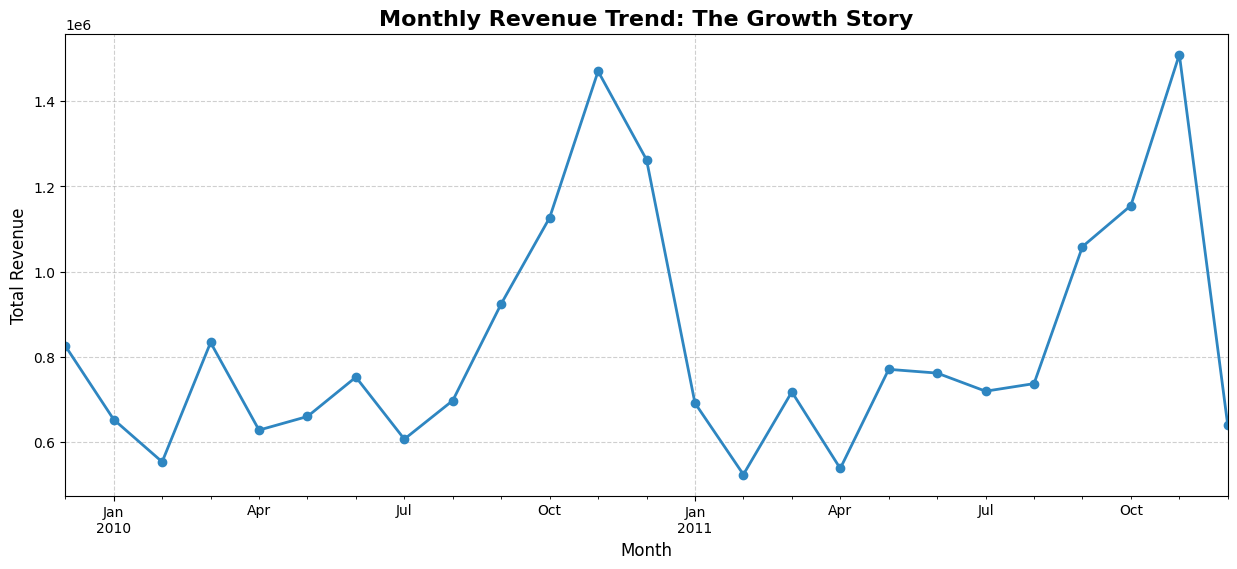

In [5]:
# Data Preparation
df['InvoiceDate'] = pd.to_datetime(df['invoice_date'])
df['Month'] = df['InvoiceDate'].dt.to_period('M')
df['Revenue'] = df['quantity'] * df['price']

# Visualizing the Trend
monthly_sales = df.groupby('Month')['Revenue'].sum()

plt.figure(figsize=(15, 6))
monthly_sales.plot(kind='line', marker='o', color='#2E86C1', linewidth=2)
plt.title('Monthly Revenue Trend: The Growth Story', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Revenue', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## 3. Shopping Habits: When do customers buy?
**Business Question:** What are the busiest times for our store? This helps in scheduling marketing emails and managing inventory.

Calculating the Recency of each customer
When is the last time did the customer buy from the shop

In [6]:
latest_date = df["invoice_date"].max()
recency = df.groupby("customer_id").agg({"invoice_date":lambda x: (latest_date-x.max()).days})
recency = recency.rename(columns={"invoice_date":"recency"})

Calculating the Frequency of each customer
How frequently does the customer buy

In [7]:
freq = df.groupby("customer_id").agg(freq=("customer_id","size"))

Calculating the monetary of each customer
Total spending

In [8]:
monetary = df.groupby("customer_id").agg(monetary=("price","sum"))

Crafting the whole table of RFM

In [9]:
rfm = recency
rfm = rfm.join(freq)
rfm = rfm.join(monetary)
rfm.head(1)

,recency,freq,monetary
customer_id,,,
12346,325,34,207.399994


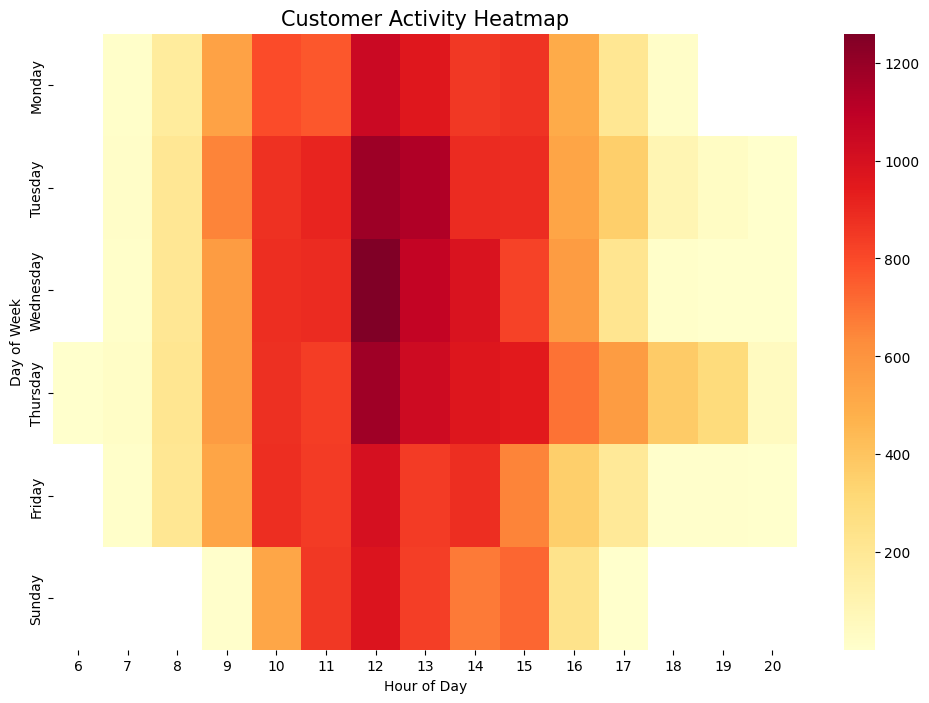

In [10]:
df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()
df['Hour'] = df['InvoiceDate'].dt.hour

# Preparing data for Heatmap
sales_heatmap = df.groupby(['DayOfWeek', 'Hour'])['invoice'].nunique().unstack()
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Sunday']
sales_heatmap = sales_heatmap.reindex(days_order)

# Plotting
plt.figure(figsize=(12, 8))
sns.heatmap(sales_heatmap, cmap='YlOrRd', annot=False, fmt='g')
plt.title('Customer Activity Heatmap', fontsize=15)
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()

Segmentation

In [11]:
# customers segmentations
rfm["R_score"] = pd.qcut(rfm["recency"],5,labels=[5,4,3,2,1])
rfm["F_score"] = pd.qcut(rfm["freq"].rank(method="first"),5,labels=[1,2,3,4,5])
rfm["M_score"] = pd.qcut(rfm["monetary"],5,labels=[1,2,3,4,5])
# Creating RFM for all aspects
rfm["RFM_score"] = rfm["R_score"].astype("str") + rfm["F_score"].astype("str") + rfm["M_score"].astype("str")

In [12]:
# Creating segments
def segment(x):
    if x["R_score"] >= 4 and x["F_score"] >= 4 and x["M_score"] >= 4:
        return "Champions (Superstars)"
    elif x["R_score"] >= 3 and x["F_score"] >= 3:
        return "Loyal Customers"
    elif x["R_score"] >= 4 and x["F_score"] <= 2:
        return "Newcomers (Potential)"
    elif x["R_score"] <= 2 and x["F_score"] >= 3:
        return "At Risk (Need Attention)"
    elif x["R_score"] <= 2 and x["F_score"] <= 2:
        return "Lost (Hibernating)"
    else:
        return "Standard Customers"

rfm["segment"] = rfm.apply(segment, axis=1)

### Insights from Segmentation:
* **Champions:** These are our most valuable customers. We should reward them.
* **At Risk:** High value in the past, but haven't purchased recently. They need immediate re-engagement campaigns.

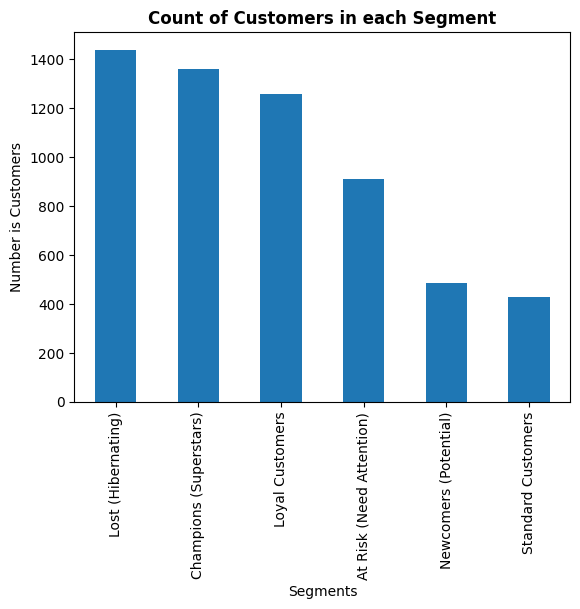

In [13]:
segment_count = rfm["segment"].value_counts()
segment_count.plot(kind="bar")
plt.title("Count of Customers in each Segment", fontweight="bold")
plt.xlabel("Segments")
plt.ylabel("Number is Customers")
plt.show()

Cohort Analysis

In [14]:
# First of all we figure the cohort month
df["cohort_month"] = df.groupby("customer_id")["invoice_date"].transform("min").dt.to_period("M")

# Now we need to figure the invoice month
df["invoice_month"] = df["invoice_date"].dt.to_period("M")

# Calculating the Cohort Index
def cohort_index(df):
    return (df["invoice_month"].dt.to_timestamp() - df["cohort_month"].dt.to_timestamp()).dt.days // 30
df["cohort_index"] = cohort_index(df)

# Calculating the Retention
cohort_data = df.groupby(["cohort_month","cohort_index"])["customer_id"].nunique().reset_index()
cohort_counts = cohort_data.pivot_table(index="cohort_month", columns="cohort_index", values="customer_id")

cohort_sizes = cohort_counts.loc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)

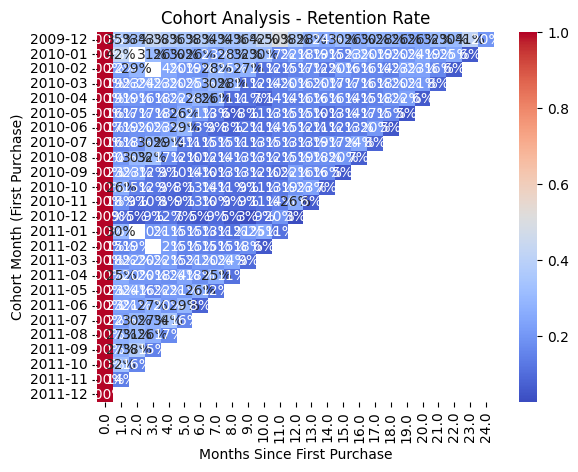

In [15]:
sns.heatmap(retention, annot=True, fmt=".0%", cmap="coolwarm", annot_kws={"size": 10},mask=retention.isnull(), linecolor="gray")
plt.title("Cohort Analysis - Retention Rate")
plt.ylabel("Cohort Month (First Purchase)")
plt.xlabel("Months Since First Purchase")
plt.show()

Product Affinity

## 4. What People Love: Product Analysis
**Business Question:** What are our most popular items that define our brand?

In [16]:
# Creating basket matrix
basket = (df.groupby(['invoice', 'stock_code'])['quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('invoice'))
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)
if 'POSTAGE' in basket_sets.columns:
    basket_sets.drop('POSTAGE', inplace=True, axis=1)
basket

/tmp/ipython-input-4233998236.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_sets = basket.applymap(encode_units)


stock_code,10002,10002R,10080,10109,10120,10123C,10123G,10124A,10124G,10125,...,gift_0001_10,gift_0001_20,gift_0001_30,gift_0001_40,gift_0001_50,gift_0001_60,gift_0001_70,gift_0001_80,gift_0001_90,m
invoice,,,,,,,,,,,,,,,,,,,,,
489434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
489435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
489436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
489437,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
489438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A516228,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A528059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A563185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules
frequent_itemsets = fpgrowth(basket_sets, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules = rules.sort_values(['lift', 'confidence'], ascending=[False, False])

print(rules[['antecedents', 'consequents', 'lift']].head(10))

/usr/local/lib/python3.12/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: Dep

     antecedents consequents       lift
1491     (22746)     (22745)  48.766994
1490     (22745)     (22746)  48.766994
1489     (22746)     (22748)  47.506696
1488     (22748)     (22746)  47.506696
1486     (22745)     (22748)  44.787359
1487     (22748)     (22745)  44.787359
31      (84596F)    (84596B)  44.064255
30      (84596B)    (84596F)  44.064255
1392     (22579)     (22578)  43.001809
1393     (22578)     (22579)  43.001809


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [18]:
print(rules[['antecedents', 'consequents', 'lift']].head(10))

     antecedents consequents       lift
1491     (22746)     (22745)  48.766994
1490     (22745)     (22746)  48.766994
1489     (22746)     (22748)  47.506696
1488     (22748)     (22746)  47.506696
1486     (22745)     (22748)  44.787359
1487     (22748)     (22745)  44.787359
31      (84596F)    (84596B)  44.064255
30      (84596B)    (84596F)  44.064255
1392     (22579)     (22578)  43.001809
1393     (22578)     (22579)  43.001809


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [19]:
products_map = df[['stock_code', 'description']].drop_duplicates('stock_code').set_index('stock_code')['description'].to_dict()

def get_product_name(item_set):
    code = list(item_set)[0]
    try:
        return products_map[code]
    except:
        return code

rules['Product_A_Name'] = rules['antecedents'].apply(get_product_name)
rules['Product_B_Name'] = rules['consequents'].apply(get_product_name)

final_view = rules[['Product_A_Name', 'Product_B_Name', 'lift', 'confidence']]
print(final_view.head(10))

                          Product_A_Name                      Product_B_Name  \
1491        POPPY'S PLAYHOUSE LIVINGROOM           POPPY'S PLAYHOUSE BEDROOM   
1490           POPPY'S PLAYHOUSE BEDROOM        POPPY'S PLAYHOUSE LIVINGROOM   
1489        POPPY'S PLAYHOUSE LIVINGROOM           POPPY'S PLAYHOUSE KITCHEN   
1488           POPPY'S PLAYHOUSE KITCHEN        POPPY'S PLAYHOUSE LIVINGROOM   
1486           POPPY'S PLAYHOUSE BEDROOM           POPPY'S PLAYHOUSE KITCHEN   
1487           POPPY'S PLAYHOUSE KITCHEN           POPPY'S PLAYHOUSE BEDROOM   
31          SMALL MARSHMALLOWS PINK BOWL  SMALL DOLLY MIX DESIGN ORANGE BOWL   
30    SMALL DOLLY MIX DESIGN ORANGE BOWL        SMALL MARSHMALLOWS PINK BOWL   
1392  WOODEN TREE CHRISTMAS SCANDINAVIAN  WOODEN STAR CHRISTMAS SCANDINAVIAN   
1393  WOODEN STAR CHRISTMAS SCANDINAVIAN  WOODEN TREE CHRISTMAS SCANDINAVIAN   

           lift  confidence  
1491  48.766994    0.817376  
1490  48.766994    0.655761  
1489  47.506696    0.840426  

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

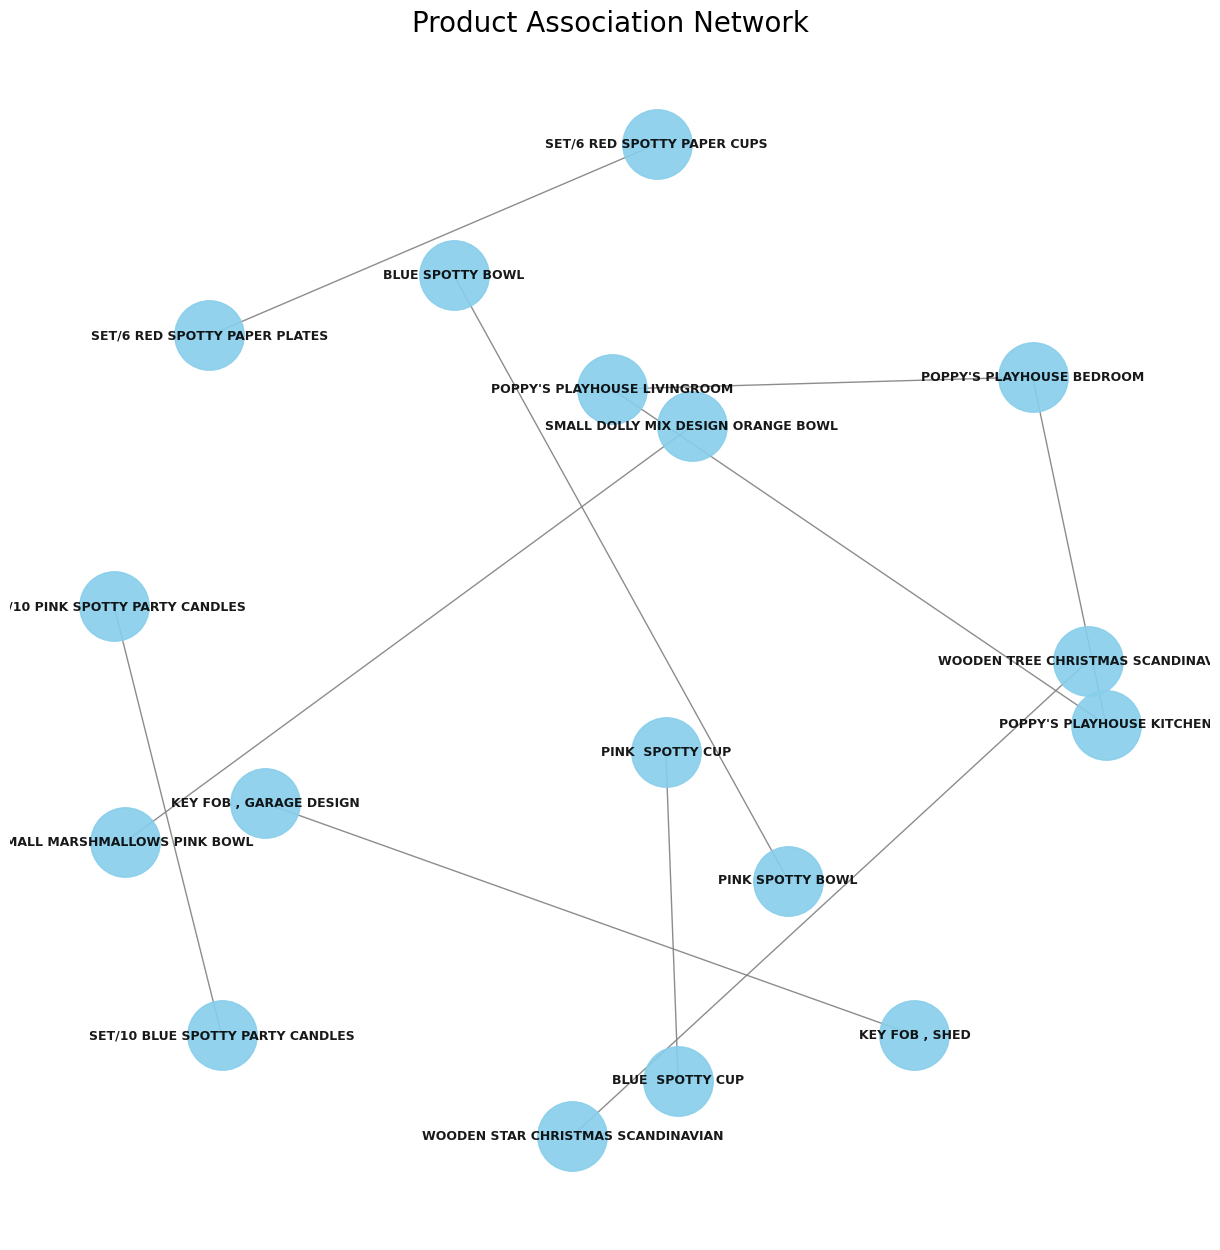

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [20]:
import networkx as nx
top_rules = final_view.head(20)

plt.figure(figsize=(12, 12))
G = nx.from_pandas_edgelist(top_rules, source='Product_A_Name', target='Product_B_Name', edge_attr='lift')
pos = nx.spring_layout(G, k=1.5)
nx.draw(G, pos,
        with_labels=True,
        node_color='skyblue',
        node_size=2500,
        edge_color='grey',
        font_size=9,
        font_weight='bold',
        node_shape='o',
        alpha=0.9)

plt.title("Product Association Network", fontsize=20)
plt.show()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

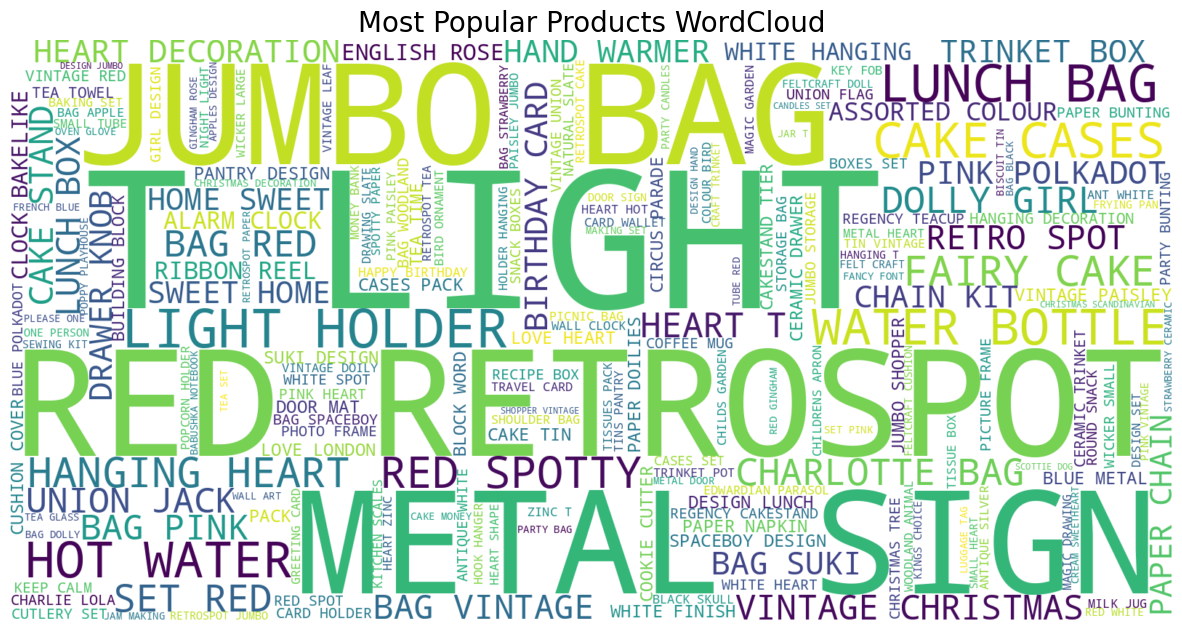

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [21]:
from wordcloud import WordCloud

text = " ".join(str(desc) for desc in df['description'].dropna())
wordcloud = WordCloud(width=1600, height=800, background_color='white', colormap='viridis').generate(text)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Popular Products WordCloud", fontsize=20)
plt.show()

## 5. Strategic Recommendations
Based on the data analysis, here are actionable steps for the business:

1.  **Targeting Timing:** The heatmap shows peak activity during mid-day on weekdays. Marketing emails should be scheduled around **10 AM - 12 PM** for maximum open rates.
2.  **Save the 'At Risk':** A specific discount campaign should be sent to the "At Risk" segment to prevent churn.
3.  **Cross-Selling:** Based on the Market Basket Analysis, we should bundle highly associated products (as identified in the network graph) to increase the Average Order Value (AOV).